# Обработчик Метеорологических Зондирований - Онлайн Демонстрация

Этот ноутбук демонстрирует использование инструмента для обработки метеорологических зондирований без необходимости устанавливать что-либо на ваш компьютер.

[![Открыть в Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meteoFurletov/weather-sounding-tool/blob/main/demo_ru.ipynb)

## 1. Настройка

Сначала установим необходимые библиотеки и клонируем репозиторий:

In [1]:
# Установка необходимых библиотек
!pip install pandas numpy requests beautifulsoup4 xlsxwriter matplotlib

# Клонирование репозитория
!git clone https://github.com/meteoFurletov/weather-sounding-tool.git
# Переход в директорию репозитория
%cd weather-sounding-tool

Cloning into 'weather-sounding-tool'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 25 (delta 10), reused 22 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 20.92 KiB | 10.46 MiB/s, done.
Resolving deltas: 100% (10/10), done.
/home/meteof/PARA/1_Projects/masters_backlog/subjects/inverse/weather-sounding-tool


## 2. Выбор параметров

Настроим основные параметры для загрузки и обработки данных:

In [3]:
# Параметры для загрузки данных
year = 2024  # Год
month = 1    # Месяц (1-12)

# Выберите станцию из списка
stations = {
    26075: "Санкт-Петербург (Воейково)",
    26702: "Москва",
    26850: "Казань",
    27612: "Екатеринбург",
    31977: "Салехард",
    32540: "Новосибирск",
    35121: "Владивосток"
}

# Выбираем станцию (можно изменить на любую из списка)
station_id = 26075
station_name = stations[station_id]

print(f"Выбраны параметры: {year} год, {month} месяц, станция: {station_name} (ID: {station_id})")

Выбраны параметры: 2024 год, 1 месяц, станция: Санкт-Петербург (Воейково) (ID: 26075)


## 3. Загрузка данных метеорологического зондирования

Теперь загрузим данные зондирования с сайта Университета Вайоминга:

In [4]:
# Импортируем необходимые функции
from weather_tool import fetch_data

# Загрузка данных
print(f"Загрузка данных для станции {station_name} за {month}.{year}...")
file_path = fetch_data(year, month, station_id)

if file_path:
    print(f"Данные успешно загружены и сохранены в {file_path}")
else:
    print("Ошибка при загрузке данных. Проверьте соединение или параметры.")

2025-03-18 18:24:07,677 - INFO - Fetching data from: http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2024&MONTH=01&FROM=0100&TO=3112&STNM=26075


Загрузка данных для станции Санкт-Петербург (Воейково) за 1.2024...


2025-03-18 18:24:15,707 - INFO - Saved raw HTML to data/response_2024_01_26075.html (59 soundings)


Данные успешно загружены и сохранены в data/response_2024_01_26075.html


## 4. Обработка данных

Теперь обработаем загруженные данные, чтобы извлечь температурные инверсии:

In [5]:
from weather_tool import process_data

# Обработка данных
print(f"Обработка данных для станции {station_name}...")
result = process_data(year, [month], station_id, use_local_files=True)

if result['processed'] > 0:
    print(f"Обработано {result['processed']} зондирований")
    print(f"Найдено инверсий: {len(result['files'])}")
    print(f"Не найдено инверсий в {result['failed']} зондированиях")
else:
    print("Не удалось найти инверсии. Проверьте данные или параметры.")

2025-03-18 18:24:20,683 - INFO - Loaded data from data/response_2024_01_26075.html
2025-03-18 18:24:20,703 - INFO - Found twice as many pre tags as h2 tags. Using every other pre tag.


2025-03-18 18:24:20,710 - INFO - Extracted 59 soundings
2025-03-18 18:24:20,746 - INFO - Saved: soundings_2024_26075/DATA_20240101_0000.xlsx
2025-03-18 18:24:20,776 - INFO - Saved: soundings_2024_26075/DATA_20240101_1200.xlsx
2025-03-18 18:24:20,800 - INFO - Saved: soundings_2024_26075/DATA_20240102_0000.xlsx
2025-03-18 18:24:20,817 - INFO - Saved: soundings_2024_26075/DATA_20240102_1200.xlsx
2025-03-18 18:24:20,836 - INFO - Saved: soundings_2024_26075/DATA_20240103_0000.xlsx
2025-03-18 18:24:20,854 - INFO - Saved: soundings_2024_26075/DATA_20240104_0000.xlsx
2025-03-18 18:24:20,879 - INFO - Saved: soundings_2024_26075/DATA_20240104_1200.xlsx


Обработка данных для станции Санкт-Петербург (Воейково)...


2025-03-18 18:24:20,899 - INFO - Saved: soundings_2024_26075/DATA_20240105_0000.xlsx
2025-03-18 18:24:20,918 - INFO - Saved: soundings_2024_26075/DATA_20240105_1200.xlsx
2025-03-18 18:24:20,939 - INFO - Saved: soundings_2024_26075/DATA_20240106_0000.xlsx
2025-03-18 18:24:20,957 - INFO - Saved: soundings_2024_26075/DATA_20240106_1200.xlsx
2025-03-18 18:24:20,975 - INFO - Saved: soundings_2024_26075/DATA_20240107_1200.xlsx
2025-03-18 18:24:20,995 - INFO - Saved: soundings_2024_26075/DATA_20240108_0000.xlsx
2025-03-18 18:24:21,019 - INFO - Saved: soundings_2024_26075/DATA_20240108_1200.xlsx
2025-03-18 18:24:21,045 - INFO - Saved: soundings_2024_26075/DATA_20240109_0000.xlsx
2025-03-18 18:24:21,070 - INFO - Saved: soundings_2024_26075/DATA_20240109_1200.xlsx
2025-03-18 18:24:21,094 - INFO - Saved: soundings_2024_26075/DATA_20240110_0000.xlsx
2025-03-18 18:24:21,118 - INFO - Saved: soundings_2024_26075/DATA_20240110_1200.xlsx
2025-03-18 18:24:21,143 - INFO - Saved: soundings_2024_26075/DATA

Обработано 51 зондирований
Найдено инверсий: 51
Не найдено инверсий в 8 зондированиях


## 5. Просмотр результатов

Рассмотрим результаты анализа:

In [6]:
import pandas as pd

# Загружаем данные из сводного файла
df = pd.read_excel('DATA.xlsx', sheet_name="df_full")

# Показываем первые несколько строк
print("Первые строки данных:")
df.head()

Первые строки данных:


,date,ΔT,ΔH,HL,TL,Ground,Night,Day
0,2024-01-01 00:00:00,2.6,164.0,72.0,-14.3,1.0,1.0,0.0
1,2024-01-01 00:00:00,2.2,100.0,821.0,-16.5,0.0,1.0,0.0
2,2024-01-01 12:00:00,4.2,873.0,245.0,-19.9,0.0,0.0,1.0
3,2024-01-02 00:00:00,4.8,238.0,72.0,-22.7,1.0,1.0,0.0
4,2024-01-02 12:00:00,1.2,271.0,72.0,-17.9,1.0,0.0,1.0


## 6. Основные статистические показатели

Рассчитаем базовую статистику по инверсиям:

In [7]:
# Отфильтруем строки, где есть данные (не NaN)
df_clean = df.dropna(subset=['ΔT'])

if len(df_clean) > 0:
    print(f"Всего инверсий: {len(df_clean)}")
    print(f"Средняя интенсивность инверсии (ΔT): {df_clean['ΔT'].mean():.2f}°C")
    print(f"Максимальная интенсивность: {df_clean['ΔT'].max():.2f}°C")
    print(f"Средняя мощность инверсии (ΔH): {df_clean['ΔH'].mean():.2f} м")
    
    ground_inv = df_clean[df_clean['Ground'] == 1]
    elevated_inv = df_clean[df_clean['Ground'] == 0]
    
    print(f"\nНаземных инверсий: {len(ground_inv)} ({len(ground_inv)/len(df_clean)*100:.1f}%)")
    print(f"Приподнятых инверсий: {len(elevated_inv)} ({len(elevated_inv)/len(df_clean)*100:.1f}%)")
    
    print(f"\nСредняя интенсивность наземных инверсий: {ground_inv['ΔT'].mean():.2f}°C")
    print(f"Средняя интенсивность приподнятых инверсий: {elevated_inv['ΔT'].mean():.2f}°C")
else:
    print("Нет данных для анализа")

Всего инверсий: 59
Средняя интенсивность инверсии (ΔT): 4.29°C
Максимальная интенсивность: 12.40°C
Средняя мощность инверсии (ΔH): 401.10 м

Наземных инверсий: 23 (39.0%)
Приподнятых инверсий: 36 (61.0%)

Средняя интенсивность наземных инверсий: 4.61°C
Средняя интенсивность приподнятых инверсий: 4.09°C


## 7. Визуализация результатов

Визуализируем обнаруженные инверсии:

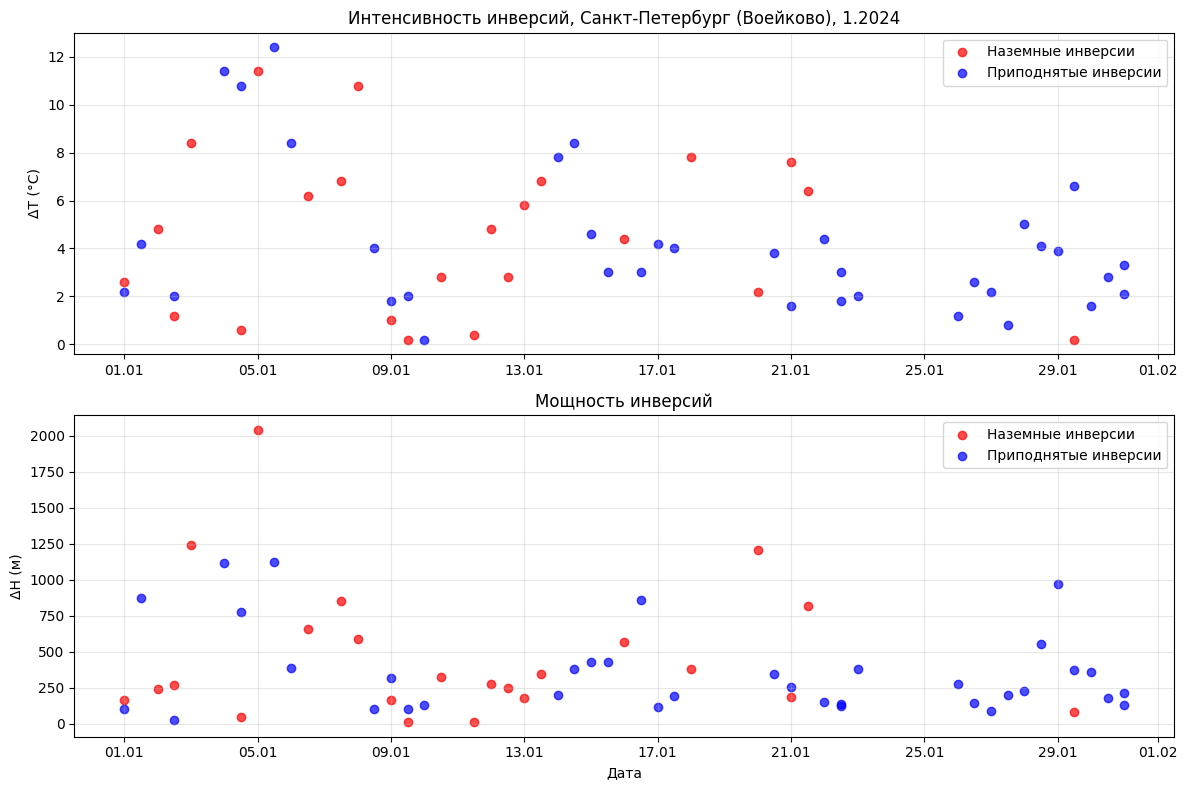

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

if len(df_clean) > 0:
    plt.figure(figsize=(12, 8))
    
    # График интенсивности инверсий по времени
    plt.subplot(211)
    ground = df_clean[df_clean['Ground'] == 1]
    elevated = df_clean[df_clean['Ground'] == 0]
    
    plt.scatter(ground['date'], ground['ΔT'], color='red', label='Наземные инверсии', alpha=0.7)
    plt.scatter(elevated['date'], elevated['ΔT'], color='blue', label='Приподнятые инверсии', alpha=0.7)
    
    plt.title(f'Интенсивность инверсий, {station_name}, {month}.{year}')
    plt.ylabel('ΔT (°C)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
    
    # График мощности инверсий
    plt.subplot(212)
    plt.scatter(ground['date'], ground['ΔH'], color='red', label='Наземные инверсии', alpha=0.7)
    plt.scatter(elevated['date'], elevated['ΔH'], color='blue', label='Приподнятые инверсии', alpha=0.7)
    
    plt.title('Мощность инверсий')
    plt.xlabel('Дата')
    plt.ylabel('ΔH (м)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
    
    plt.tight_layout()
    plt.show()
else:
    print("Недостаточно данных для построения графика")

## 8. Сравнение дневных и ночных инверсий

Дневных инверсий: 20
Ночных инверсий: 28

Сравнение интенсивности:
Средняя ΔT днём: 3.90°C
Средняя ΔT ночью: 4.23°C

Сравнение мощности:
Средняя ΔH днём: 420.45 м
Средняя ΔH ночью: 303.04 м


<Figure size 1000x600 with 0 Axes>

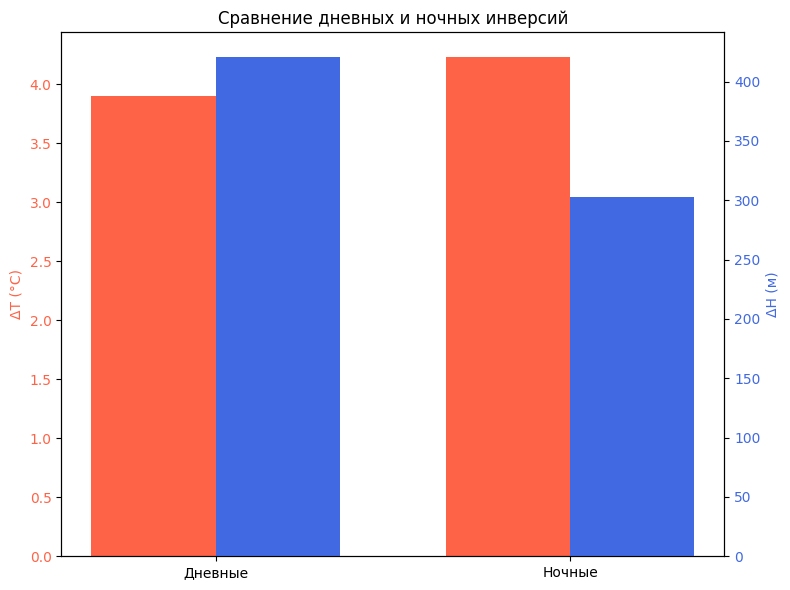

In [7]:
if len(df_clean) > 0:
    day = df_clean[df_clean['Day'] == 1]
    night = df_clean[df_clean['Night'] == 1]
    
    print(f"Дневных инверсий: {len(day)}")
    print(f"Ночных инверсий: {len(night)}")
    
    if len(day) > 0 and len(night) > 0:
        print("\nСравнение интенсивности:")
        print(f"Средняя ΔT днём: {day['ΔT'].mean():.2f}°C")
        print(f"Средняя ΔT ночью: {night['ΔT'].mean():.2f}°C")
        
        print("\nСравнение мощности:")
        print(f"Средняя ΔH днём: {day['ΔH'].mean():.2f} м")
        print(f"Средняя ΔH ночью: {night['ΔH'].mean():.2f} м")
        
        # Визуализация сравнения
        plt.figure(figsize=(10, 6))
        
        # Интенсивность
        labels = ['Дневные', 'Ночные']
        dt_values = [day['ΔT'].mean(), night['ΔT'].mean()]
        dh_values = [day['ΔH'].mean(), night['ΔH'].mean()]
        
        x = range(len(labels))
        width = 0.35
        
        fig, ax1 = plt.subplots(figsize=(8, 6))
        
        ax1.bar(x, dt_values, width, label='ΔT (°C)', color='tomato')
        ax1.set_ylabel('ΔT (°C)', color='tomato')
        ax1.tick_params(axis='y', labelcolor='tomato')
        
        ax2 = ax1.twinx()
        ax2.bar([i + width for i in x], dh_values, width, label='ΔH (м)', color='royalblue')
        ax2.set_ylabel('ΔH (м)', color='royalblue')
        ax2.tick_params(axis='y', labelcolor='royalblue')
        
        plt.title('Сравнение дневных и ночных инверсий')
        plt.xticks([i + width/2 for i in x], labels)
        plt.tight_layout()
        plt.show()
else:
    print("Недостаточно данных для анализа")

## 9. Загрузка результатов

Вы можете скачать сводную таблицу с результатами:

In [ ]:
from google.colab import files

# Загрузка сводного файла анализа
files.download('DATA.xlsx')

## Заключение

В этом ноутбуке мы:
1. Загрузили данные метеорологических зондирований
2. Обработали их для выявления температурных инверсий
3. Проанализировали характеристики инверсий
4. Визуализировали результаты
5. Сравнили дневные и ночные инверсии

Для дальнейшего анализа вы можете:
- Изменить период анализа (год, месяц)
- Выбрать другую метеостанцию
- Сравнить данные между несколькими станциями
- Использовать более сложный статистический анализ